In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

import numpy as np

import matplotlib.pyplot as plt

import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name() if torch.cuda.is_available() else 'cpu')

# Random seed for reproducibility
torch.manual_seed(333667)

NVIDIA GeForce RTX 3050 6GB Laptop GPU


# Simulation Config


In [2]:
# Spatial Domain
xmin, xmax = 0, 2*np.pi  # Domain limits
Nx = 512                        # Number of Spatial points
L = abs(xmax - xmin)            # Domain Length
dx = L / (Nx - 1)               # Cell width

_x = torch.linspace(xmin, xmax, Nx, requires_grad=True).view(-1, 1).to(device)

# Temporal Domain
Tf = 2.0                # Final time
dt = 0.01               # Time step
Nt = int(Tf / dt) + 1   # Number of temporal points

_t = torch.linspace(0, Tf, Nt, requires_grad=True).view(-1, 1).to(device)

# Mesh
t_mesh, x_mesh = torch.meshgrid(_t.squeeze(1), _x.squeeze(1), indexing='ij')
x, t = x_mesh.reshape(-1, 1), t_mesh.reshape(-1, 1)


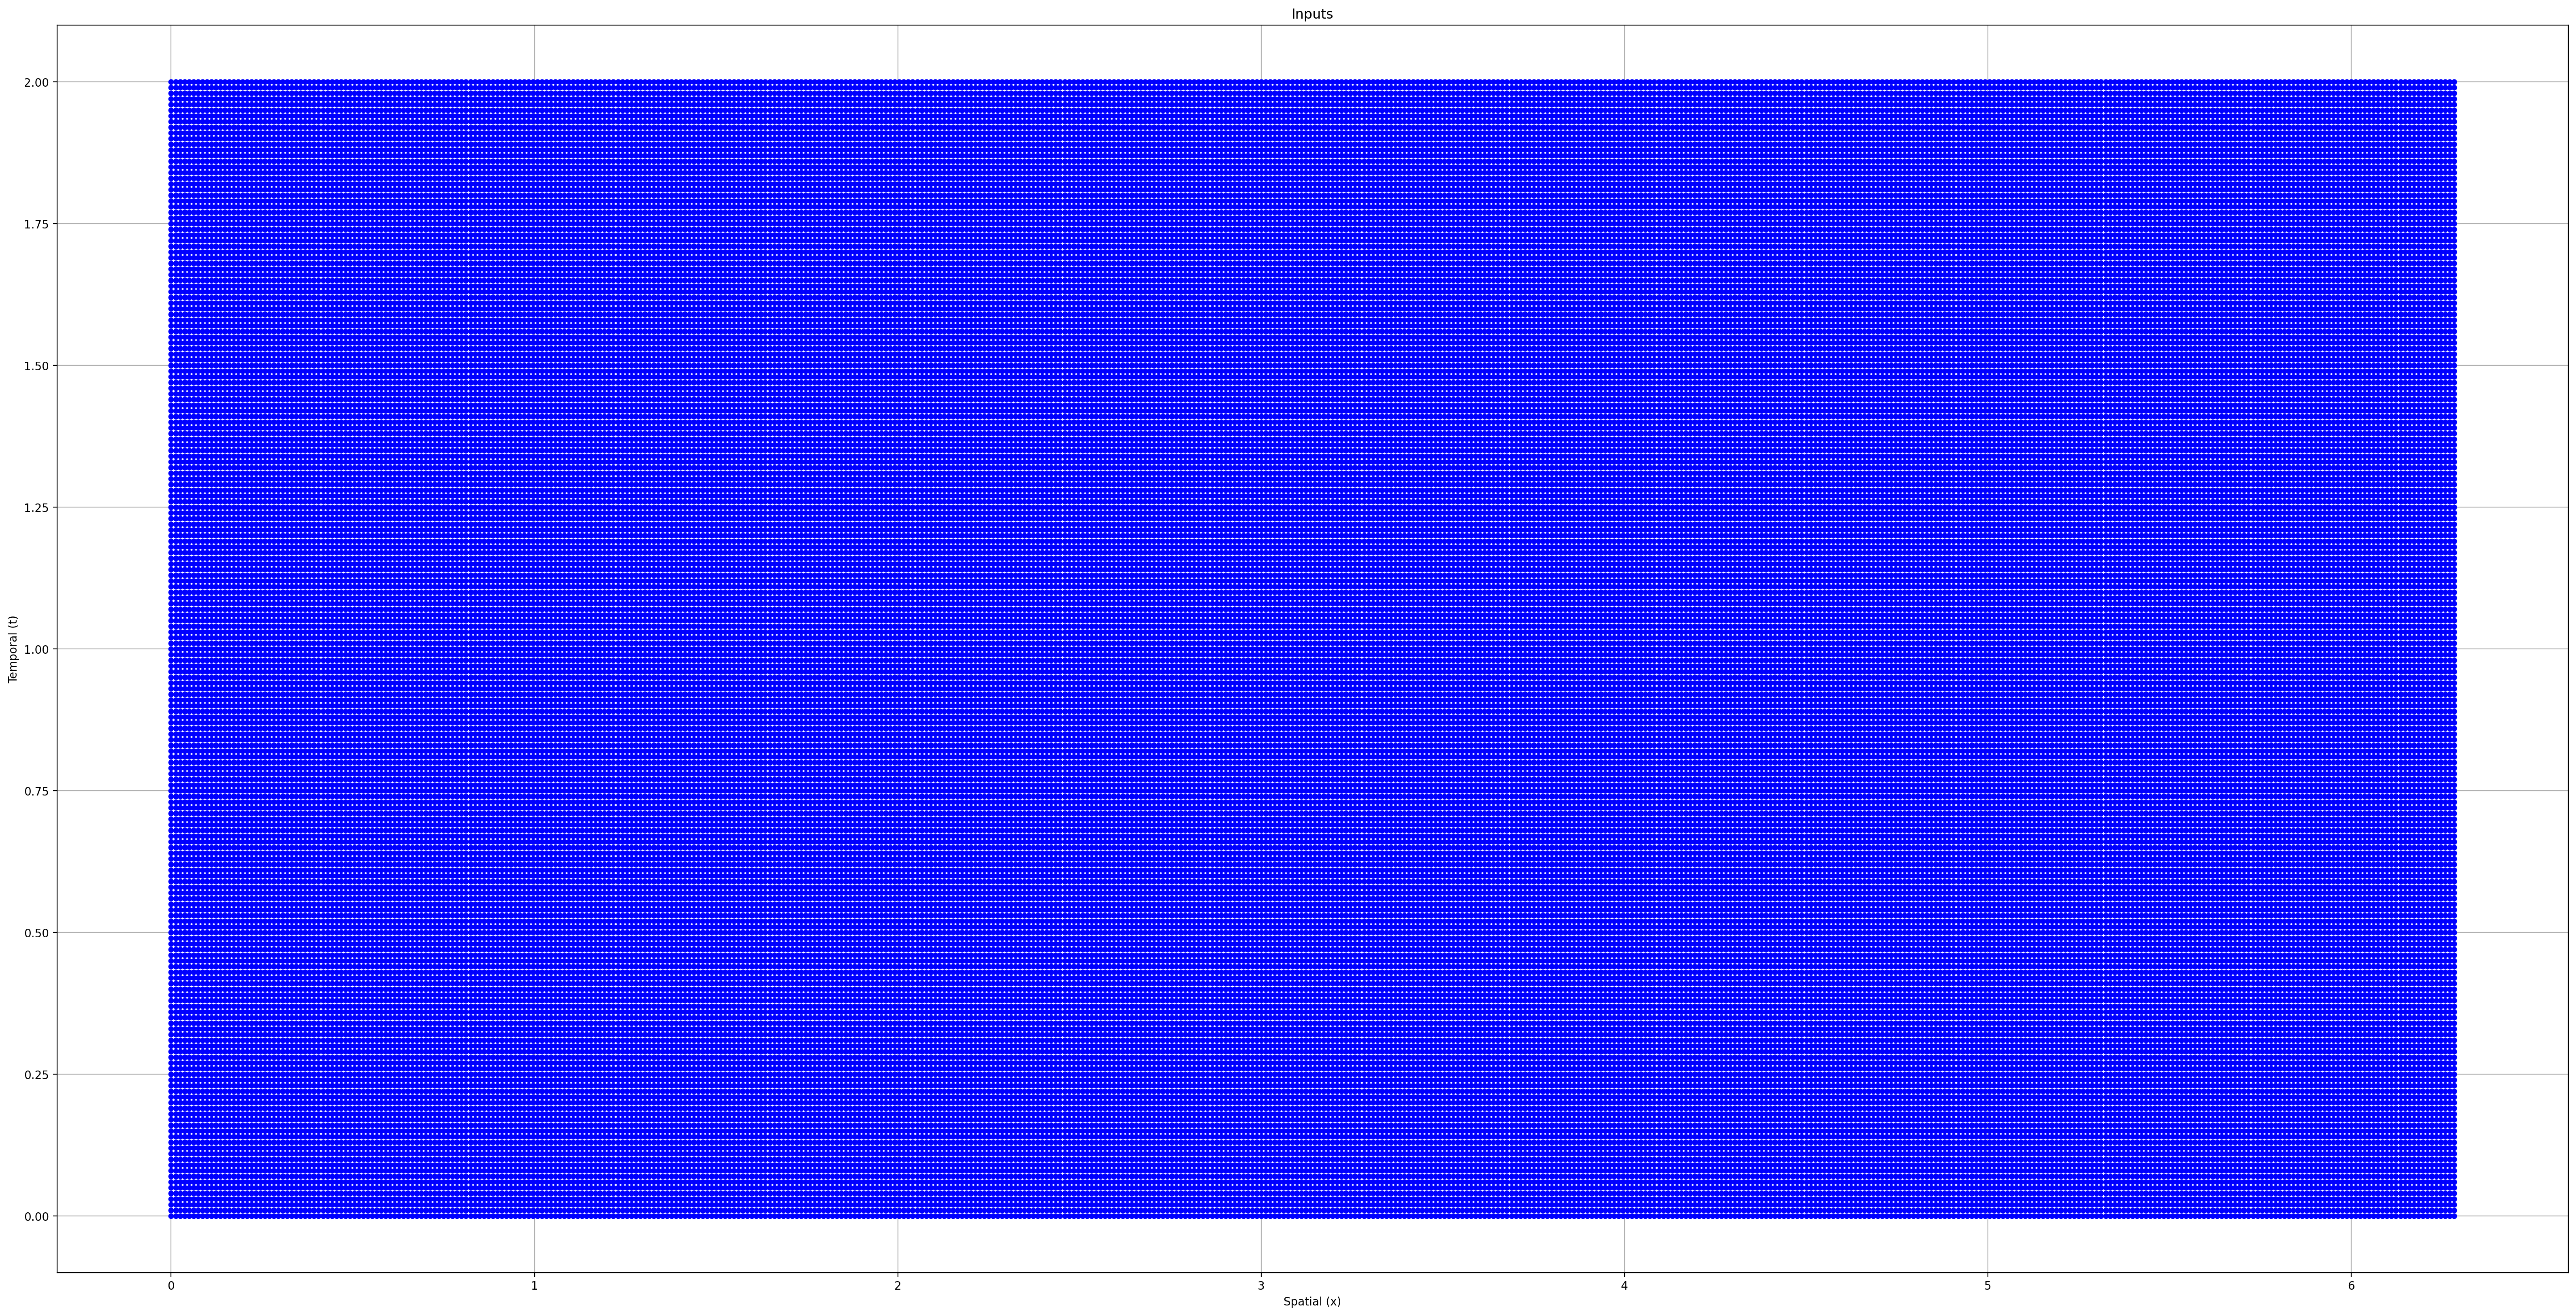

In [3]:
# x_np = _x.detach().cpu().numpy()
# t_np = _t.detach().cpu().numpy()

plt.figure(figsize=(40, 20), dpi=200)
plt.plot(x_mesh.detach().cpu().numpy(), t_mesh.detach().cpu().numpy(), 'bo', markersize=4)
# plt.plot(x_np, np.zeros_like(x_np), label='x (Spatial)', marker='o', markerfacecolor='none')
# plt.plot(np.zeros_like(t_np), t_np, label='t (Temporal)', marker='x', color='orange')
plt.title('Inputs')
plt.xlabel('Spatial (x)')
plt.ylabel('Temporal (t)')
plt.grid(True, linestyle='-', alpha=1)
plt.show()

# Helper

In [4]:
def plot():
    """
    Plot the sim_data from the PINN model and the exact solution.
    
    Args:-
    - sim_data: Predicted values for each time step (2D array: time x space).
    - ex_data: Optional exact solution data (same shape as sim_data) | Taken from extremely fine mesh using FVM
    """
    sim_data = np.loadtxt('simulation_data.txt')

    x = np.linspace(xmin, xmax, Nx)
    
    time_steps = len(sim_data)
    Dt = Tf / (time_steps-1)
    
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\mu(\theta)$')

    for _, t__ in enumerate([0, 16, 32, 64, 128, 200]):
        plt.clf()
        plt.title(f'PINN Simulation at t={round(t__*Dt, 3)}')

        # Exact Solution
        if ex_data_exists and (t__ == Nt-1 or t__ == 0):
            __t = -1 if t__ == Nt-1 else 0
            plt.plot(x, uex[__t, :], linestyle=":", marker="o", markersize=1, markerfacecolor='none', label='Exact Solution', color='r')
        # PINN Solution
        plt.plot(x, sim_data[t__, :], linestyle=":", marker="x", markersize=3, label='PINN Prediction', color='b')
        
        plt.savefig(f'steps/{t__}.png', bbox_inches='tight')
        plt.legend()
        plt.draw()
        plt.pause(0.08)

    plt.show()


def write_data(file, u):
    """
    Write the simulation results to a file.
    
    Args:-
    - filename: The file object to write to.
    - u: The array of predicted values (1D array for a single time step).
    """
    file.write(" ".join(map(str, u)) + "\n")


def get_param():
    """
    Print the simulation parameters relevant to the PINN model.
    """
    print("\nPINN Simulation Parameters\n")
    print(f"Domain Limits (xmin, xmax): {xmin} , {xmax}")
    print(f"Domain Length (L): {L}")
    print(f"Number of Spatial Points (Nx): {Nx}")
    print(f"Cell Width (dx): {dx}\n")
    print(f"Final Time (Tf): {Tf}\n")
    print(f"Time Step (dt): {dt}")
    print(f"Number of Time Steps (Nt): {Nt}\n")


# PDE Setup

In [5]:
def initialise(x_tensor, condition):
    """
    Initialize the solution based on different initial conditions.
    
    Args:-
    - x_tensor: Tensor of Nx spatial points.
    - condition: Integer representing the type of initial condition to use.
    
    Returns:
    - u_0: Initial condition evaluated at the spatial points x.
    """
    if condition == 1:
        # Singular initial data
        print("Initial Condition: 1/4 * ((x_j >= 3*pi/4) && (x_j <= 5*pi/4)) + 1/2 * ((x_j >= pi/2) && (x_j <= 3*pi/2)")
        u_0 = 0.25 * ((x_tensor >= 3*np.pi/4) & (x_tensor <= 5*np.pi/4)) + \
              0.5 * ((x_tensor >= np.pi/2) & (x_tensor <= 3*np.pi/2))
    elif condition == 2:
        # Polynomial initial data
        print("Initial Condition: (6/pi^3) * (3*pi/2 - x) * (x - pi/2), if pi/2 <= x < 3*pi/2; 0 otherwise.")

        u_0 = torch.where((x_tensor >= np.pi/2) & (x_tensor < 3*np.pi/2),
                          (6/np.pi**3) * (3*np.pi/2 - x_tensor) * (x_tensor - np.pi/2),
                          torch.zeros_like(x_tensor))
    elif condition == 3:
        # Sine initial data
        print("Initial Condition: sin(x)")
        u_0 = torch.sin(x_tensor)

    return u_0


# Fne Mesh / Exact Solution
EXACT_FILE = "u_ex.txt"
ex_data_exists = os.path.getsize(EXACT_FILE) > 0
if ex_data_exists:
    uex = np.loadtxt(EXACT_FILE)


# PDE Flux
def flux(u, x_tensor):
    # rho = torch.trapz(u.squeeze(), x_tensor.squeeze())*dx
    # om = rho * torch.sin(x_tensor)
    # return -torch.trapz(om.squeeze(), x_tensor.squeeze())*dx * u
    return torch.real(torch.fft.ifft(torch.fft.fft(torch.sin(x_tensor)) * torch.fft.fft(u))) * u 
    # return 0.5*u*u


# Initial data
u_0 = initialise(_x, 2).to(device)

Initial Condition: (6/pi^3) * (3*pi/2 - x) * (x - pi/2), if pi/2 <= x < 3*pi/2; 0 otherwise.


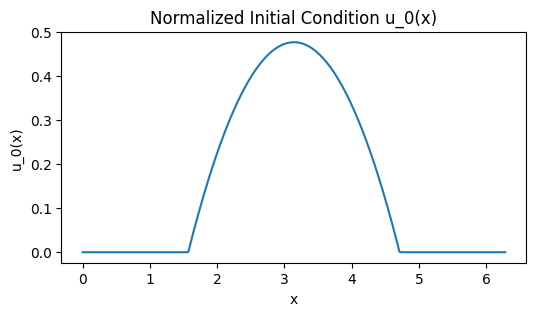

In [6]:
plt.figure(figsize=(6, 3))
plt.plot(_x.detach().cpu().numpy(), u_0.detach().cpu().numpy(), label='Initial Condition')
plt.title('Normalized Initial Condition u_0(x)')
plt.xlabel('x')
plt.ylabel('u_0(x)')
plt.show()

# Network Architecture
### Simple FeedForward Neural Network

-> 1 input layer

-> 4 fully connected hidden layers; 64 neurons each

-> 1 output layer

In [7]:
class PINN(nn.Module):
    def __init__(self, layers, units):
        """
        Initialise the PINN model.
        
        Args:-
        - layers: number of hidden layers
        - units: number of neurons in each hidden layer 
        """
        super(PINN, self).__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(2, units)) # input layer ~> {x, t}
        for _ in range(layers): 
            self.layers.append(nn.Linear(units, units))   # hidden layers
        self.layers.append(nn.Linear(units, 1)) # output layer ~> u(x, t)

        self.init_weights()

    
    def forward(self, x_tensor, t_tensor):
        """
        Forward pass through the network. It takes in time `t` and space `x` and outputs the solution `u(x, t)`.
        
        Args:-
        - x_tensor: Mesh of Nt*Nx space values 
        - t_tensor: Mesh of Nt*Nx temporal values
        
        Returns:
        - u: Neural network output representing the function `u(x, t)`.
        """
        t_ = t_tensor
        x_ = x_tensor
        
        inputs = torch.cat([t_, x_], dim=1)
        for layer in self.layers[:-1]:
            inputs = torch.tanh(layer(inputs))      # tanh activation
        output = self.layers[-1](inputs)

        return output


    def init_weights(self):
        """
        Initialises layer weights using Glorot Normal Distribution
        """
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
    

    def pde_residual(self, x_tensor, t_tensor):
        """
        Compute the residual of the PDE: u_t + f(u)_x = 0
        f(u) = -k*V(u)*u
        
        Args:-
        - x_tensor: Mesh of Nt*Nx space values
        - t_tensor: Mesh of Nt*Nx temporal values
        
        Returns:
        - residual: The residual of the PDE at the given points (t, x).
        """
        u = self.forward(x_tensor, t_tensor)

        scale = torch.ones_like(u)
        u_t = torch.autograd.grad(u, t_tensor, grad_outputs=scale, create_graph=True)[0]
        # fu_x = torch.autograd.grad(flux(u, x_tensor), x_tensor, grad_outputs=scale, create_graph=True)[0]
        fu_x = flux(u, x_tensor)
        
        # residual = u_t + (-k*V(u)*u)_x
        return u_t + fu_x


    def loss(self, x_tensor, t_tensor, u_0):
        """
        Compute the total loss function including PDE residuals, initial, and boundary conditions.
        
        Args:-
        - x_tensor: Mesh of Nt*Nx space values.
        - t_tensor: Mesh of Nt*Nx temporal values.
        - u_0: Tensor of initial condition values for u_0(x).
        
        Returns:
        - total_loss: The total loss combining PDE residuals, initial condition loss, and boundary loss.
        """
        res = bc = ic = 0

        # PDE residual loss
        res += torch.mean(torch.square(self.pde_residual(x_tensor, t_tensor).reshape(x_mesh.shape)))

        # Boundary condition loss
        x_left = torch.full_like(_t, xmin).to(device)
        x_right = torch.full_like(_t, xmax).to(device)
        
        u_left = self.forward(x_left, _t)
        u_right = self.forward(x_right, _t)

        bc += torch.mean(torch.square(u_left - u_right))

        # Initial condition loss
        u_0_pred = self.forward(_x, torch.zeros_like(_x))
        ic += torch.mean(torch.square(u_0_pred - u_0))

        total_loss = 1*res + 1*ic + 1*bc
        
        return total_loss, res, bc, ic


    def trainer(self, x_tensor, t_tensor, u_0, epochs=10240, lr=1e-4):
        """
        Train the PINN using the provided data and physics constraints.
        
        Args:-
        - x_tensor: Mesh of Nt*Nx space values.
        - t_tensor: Mesh of Nt*Nx temporal values.
        - u_0: Tensor of initial condition values for u(x, t0).
        - epochs: Number of training epochs.
        - lr: Learning rate for the optimizer.
        """
        # Adam optimizer
        optimizer = optim.Adam(self.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=16)
        
        loss_list = []
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            
            loss, res, bc, ic = self.loss(x_tensor, t_tensor, u_0)
            loss_list.append(loss.item())

            loss.backward(retain_graph=True)
            optimizer.step()
            
            scheduler.step(loss)

            if epoch % 128 == 0:
                print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}, Res: {res}, BC: {bc}, IC: {ic}, LR: {scheduler.get_last_lr()[0]}')
        
        print("Training complete.")
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}, Res: {res}, BC: {bc}, IC: {ic}, LR: {scheduler.get_last_lr()[0]}')

        plt.semilogy(range(len(loss_list)), loss_list)
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.title("Training Loss over Epochs")

model = PINN(layers=4, units=64).to(device)

C:\Users\89\AppData\Roaming\Python\Python312\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0/10240, Loss: 0.07121839374303818, Res: 0.0003899102739524096, BC: 0.0007509353454224765, IC: 0.07007754594087601, LR: 0.0001
Epoch 128/10240, Loss: 0.02170291356742382, Res: 0.0006015227409079671, BC: 0.0002399065560894087, IC: 0.020861484110355377, LR: 0.0001
Epoch 256/10240, Loss: 0.014149144291877747, Res: 0.0006107406225055456, BC: 0.00013486579700838774, IC: 0.013403537683188915, LR: 0.0001
Epoch 384/10240, Loss: 0.010084325447678566, Res: 0.0008083212305791676, BC: 2.490708720870316e-05, IC: 0.009251097217202187, LR: 0.0001
Epoch 512/10240, Loss: 0.008820765651762486, Res: 0.0008612540550529957, BC: 0.00011207068746443838, IC: 0.007847441360354424, LR: 0.0001
Epoch 640/10240, Loss: 0.007944799959659576, Res: 0.000804859446361661, BC: 0.0001196260709548369, IC: 0.00702031422406435, LR: 0.0001
Epoch 768/10240, Loss: 0.006913884077221155, Res: 0.0007326085469685495, BC: 0.0001109673103201203, IC: 0.0060703083872795105, LR: 0.0001
Epoch 896/10240, Loss: 0.005541930440813303, 

Layer (type:depth-idx)                   Param #
PINN                                     --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       192
│    └─Linear: 2-2                       4,160
│    └─Linear: 2-3                       4,160
│    └─Linear: 2-4                       4,160
│    └─Linear: 2-5                       4,160
│    └─Linear: 2-6                       65
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0

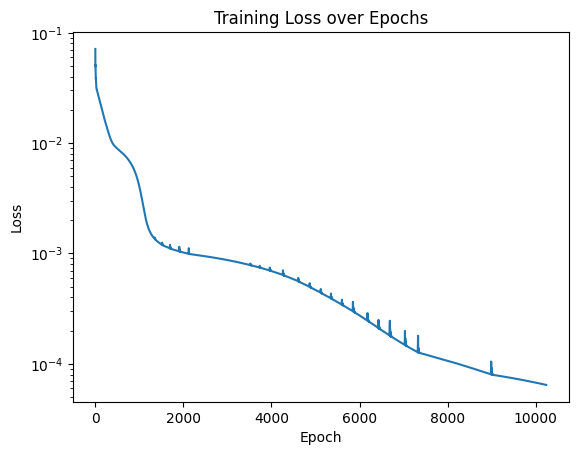

In [8]:
model.trainer(x, t, u_0)
summary(model)

# Prediction


PINN Simulation Parameters

Domain Limits (xmin, xmax): 0 , 6.283185307179586
Domain Length (L): 6.283185307179586
Number of Spatial Points (Nx): 512
Cell Width (dx): 0.012295861657885687

Final Time (Tf): 2.0

Time Step (dt): 0.01
Number of Time Steps (Nt): 201

torch.Size([201, 512])


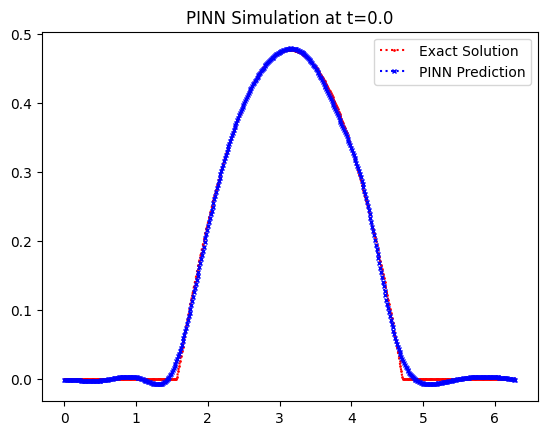

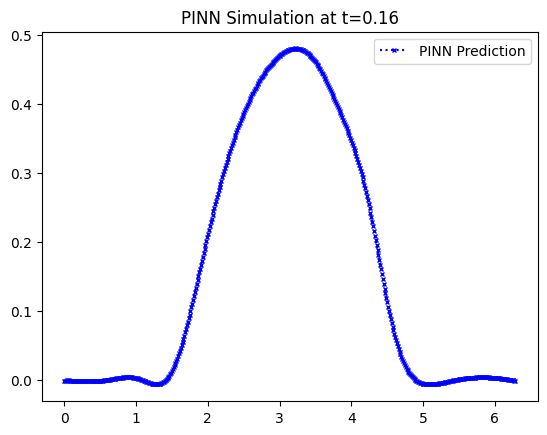

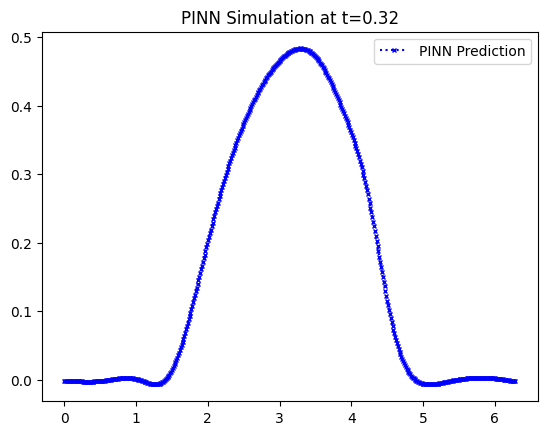

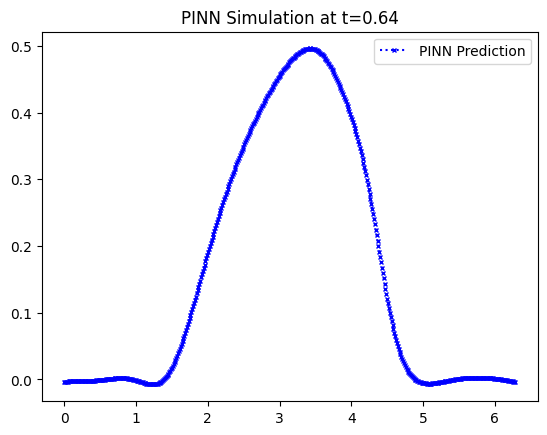

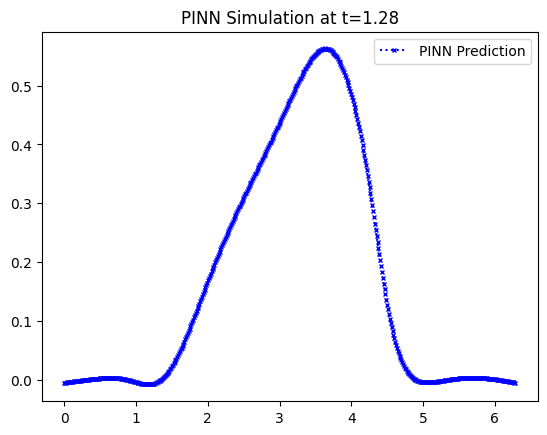

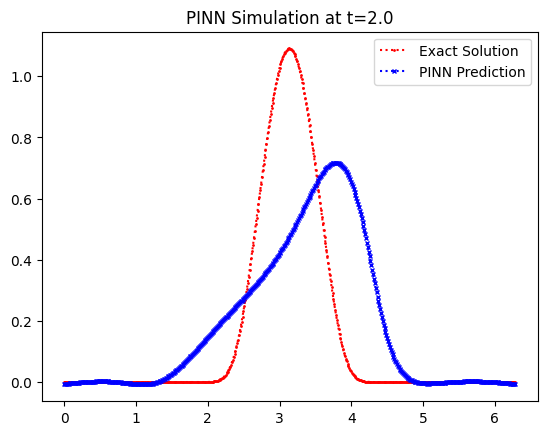

In [9]:
get_param()

model.eval()
with torch.no_grad():
    u_n = model(x, t).reshape(x_mesh.shape)
    print(u_n.shape)

WRITE_FILE = "simulation_data.txt"
out_file = open(WRITE_FILE, 'w')
for time_step in range(len(_t)):
    write_data(out_file, u_n[time_step, :].detach().cpu().numpy().flatten())
out_file.close()

plot()

In [10]:
! python -u "steps/gif.py"